In [1]:
# import jax
# import jax.numpy as jnp

# jax.config.update("jax_compilation_cache_dir", "./jax-caches")
# jax.config.update("jax_persistent_cache_min_entry_size_bytes", -1)
# jax.config.update("jax_persistent_cache_min_compile_time_secs", 0)

In [2]:
import sys
import os

sys.path.insert(0, os.path.abspath("."))
sys.path.insert(0, os.path.abspath("."))
sys.path.append(os.path.abspath("../"))

# os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = "0.25"
# os.environ["XLA_PYTHON_CLIENT_ALLOCATOR"] = "platform"
# os.environ["XLA_FLAGS"] = (
#     "--xla_disable_hlo_passes=constant_folding "  # this disables constant folding
#     # "--xla_cpu_use_thunk_runtime=false "
# )
from desc import set_device
set_device("gpu")

In [3]:
# import jax
# import jax.numpy as jnp

# jax.config.update("jax_explain_cache_misses", True)

In [4]:
# from desc import set_device, _set_cpu_count

# num_device = 2
# _set_cpu_count(num_device)
# set_device("cpu", num_device=num_device)

In [5]:
import numpy as np
np.set_printoptions(linewidth=np.inf, precision=4, suppress=True, threshold=sys.maxsize)
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.graph_objects as go
import functools
import scipy

In [6]:
import desc

from desc.basis import *
from desc.backend import *
from desc.compute import *
from desc.coils import *
from desc.equilibrium import *
from desc.examples import *
from desc.grid import *
from desc.geometry import *

from desc.objectives import *
from desc.objectives.objective_funs import *
from desc.objectives.getters import *
from desc.objectives.normalization import compute_scaling_factors
from desc.objectives.utils import *
from desc.optimize._constraint_wrappers import *

from desc.transform import Transform
from desc.plotting import *
from desc.optimize import *
from desc.perturbations import *
from desc.profiles import *
from desc.compat import *
from desc.utils import *
from desc.magnetic_fields import *

from desc.__main__ import main
from desc.vmec_utils import vmec_boundary_subspace
from desc.input_reader import InputReader
from desc.continuation import solve_continuation_automatic
from desc.compute.data_index import register_compute_fun
from desc.optimize.utils import solve_triangular_regularized

print_backend_info()

DESC version=0.15.0+40.g4e527932c.
Using JAX backend: jax version=0.6.2, jaxlib version=0.6.2, dtype=float64.
Using device: NVIDIA GeForce RTX 4080 Laptop GPU (id=0), with 10.38 GB available memory.


In [7]:
eq = get("ATF")

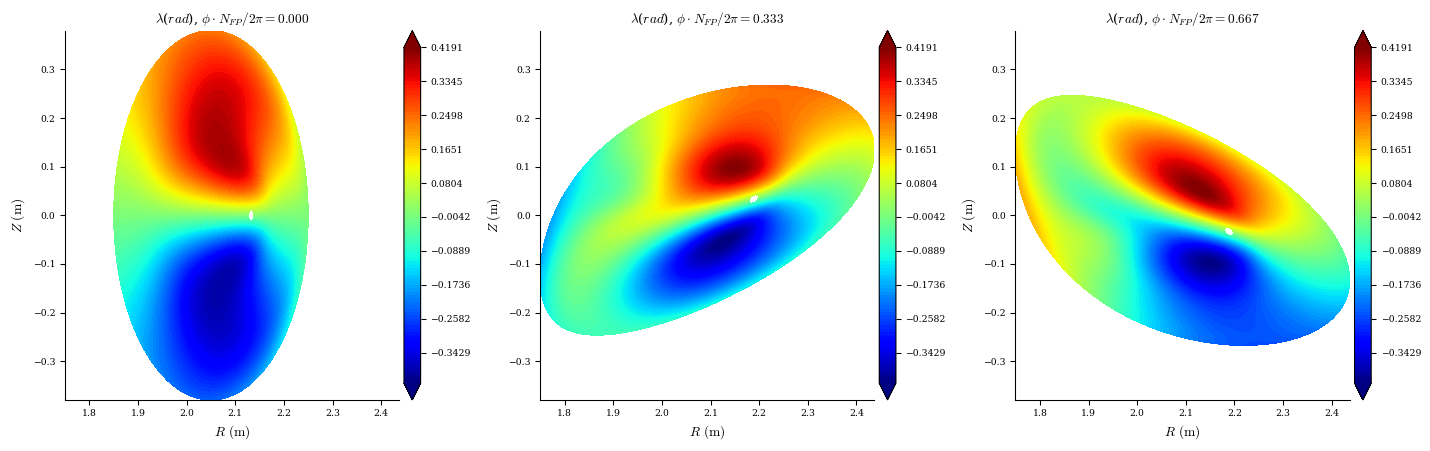

In [8]:
levels = np.linspace(0, 2*np.pi, 20, endpoint=False)
# plot_section(eq, "theta", fill=False, phi=3, levels=levels)
# plt.savefig("ATF_constant_theta.png", dpi=300)
# plot_section(eq, "theta_PEST", fill=False, phi=3, levels=levels)
# plt.savefig("ATF_constant_thetaPEST.png", dpi=300)
plot_section(eq, "lambda", fill=True, phi=3);
plt.savefig("ATF_lambda.png", dpi=300)

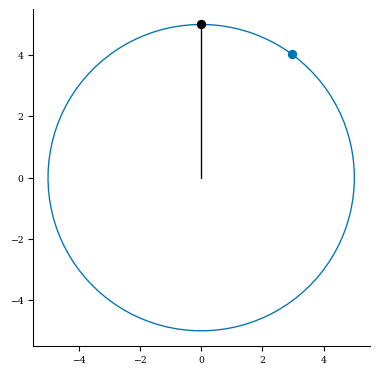

In [9]:
from desc.plotting import colorblind_colors
theta = np.linspace(0, 2*np.pi, 100)
R = 5 * np.sin(theta)
Z = 5 * np.cos(theta)
plt.figure()
plt.plot(R, Z)
plt.plot(R[0], Z[0], "ko")
plt.plot([0, R[0]], [0, Z[0]], "k")
plt.scatter(R[10], Z[10])
plt.gca().set_aspect("equal")

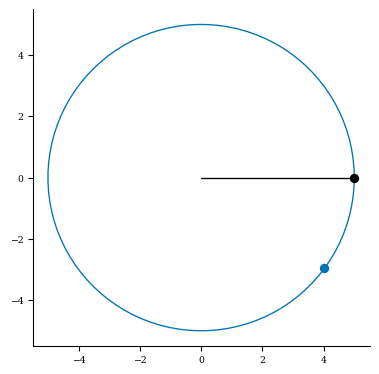

In [10]:
theta = np.linspace(0, 2 * np.pi, 100)
R = 5 * np.cos(theta)
Z = -5 * np.sin(theta)
plt.plot(R, Z)
plt.plot(R[0], Z[0], "ko")
plt.plot([0, R[0]], [0, Z[0]], "k")
plt.scatter(R[10], Z[10])
plt.gca().set_aspect("equal")

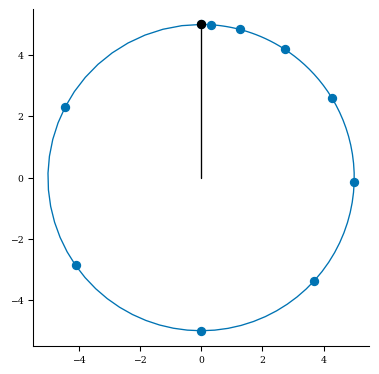

In [11]:
theta = np.linspace(0, 2 * np.pi, 100)
theta = theta**2 / (2 * np.pi)
R = 5 * np.sin(theta)
Z = 5 * np.cos(theta)
plt.plot(R, Z)
plt.plot(R[0], Z[0], "ko")
plt.plot([0, R[0]], [0, Z[0]], "k")
plt.scatter(R[::10], Z[::10])
plt.gca().set_aspect("equal")

# Magnetic Field on LCFS

In [12]:
eq = get("precise_QA")

In [54]:
data_keys = [
    "B",
    "B^theta",
    "B^zeta",
    "B_theta",
    "B_zeta",
    "lambda",
]
grid = LinearGrid(rho=1.0, M=12, N=12, NFP=eq.NFP, sym=False)
data = eq.compute(data_keys, grid=grid)

In [55]:
data.keys()

dict_keys(['iota_den', 'iota_num vacuum', 'rho', 'psi_r', 'R', 'R_r', 'Z_r', '0', 'omega_r', 'e_rho', 'R_t', 'Z_t', 'omega_t', 'e_theta', 'R_z', 'Z_z', 'omega_z', 'e_zeta', 'sqrt(g)', 'psi_r/sqrt(g)', 'iota_num current', 'iota_num', 'iota', 'phi_z', 'lambda_z', 'B^theta', 'lambda_t', 'theta_PEST_t', 'B^zeta', 'B', 'B_theta', 'B_zeta', 'lambda'])

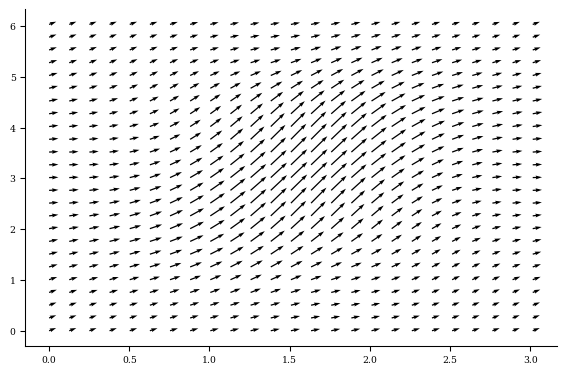

In [56]:
plt.quiver(grid.nodes[:, 2], grid.nodes[:, 1], data["B^zeta"], data["B^theta"])

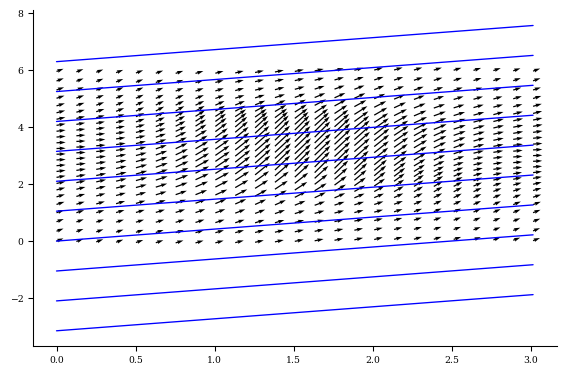

In [ ]:
start = np.linspace(-np.pi, 2*np.pi, 10)
end = start + data["iota"][0]*grid.nodes[:, 2].max()
# plt.quiver(
#     grid.nodes[:, 2],
#     grid.nodes[:, 1] + data["lambda"],
#     data["B^zeta"],
#     data["iota"] * data["B^zeta"],
# )
plt.quiver(
    grid.nodes[:, 2],
    grid.nodes[:, 1] + data["lambda"],
    data["B^zeta"],
    data["B^theta"],
)
# plt.plot(
#     np.vstack([np.zeros_like(start), np.ones_like(start) * grid.nodes[:, 2].max()]),
#     np.vstack([start, end]),
#     "b",
# )
# plt.plot([0, np.pi], [0, data["iota"][0] * np.pi], "r")
# plt.xlim([grid.nodes[:, 2].min(), grid.nodes[:, 2].max()])
# plt.ylim([grid.nodes[:, 1].min(), grid.nodes[:, 1].max()])